## 0. Import Required Packages

In [2]:
#a super learner model for regression
from math import sqrt
from numpy import vstack
from numpy import asarray
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

Using TensorFlow backend.


In [3]:
import numpy as np
import pandas as pd
from numpy import hstack
from numpy import array
import pygeostat as gs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess as sp
%pylab inline --no-import-all
from subprocess import check_output
import tensorflow as tf
from tensorflow.python import debug as tf_debug
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Populating the interactive namespace from numpy and matplotlib


C:\Users\gamze\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Grid Definition  and Dataset Description

In [4]:
griddef = gs.GridDef(gridfl='griddef.txt')
griddef

Pygeostat GridDef:
35 500.0 100.0 
60 5000.0 100.0 
15 145.0 10.0

### Produce blind data

In [4]:
kfold = gs.Program('./packages/kfold', getpar=True)

C:\Users\gamze\Desktop\SCI Paper 1-son - Major\Codes\Oilsands comparision -OK+SL\tmpstxstxhc\kfold.par has been copied to the clipboard


In [5]:
## Create Datanew = Training01
##        Datatest = Validation01

parstr = """                  Parameters for KFOLD
                  ********************

START OF PARAMETERS:
oilsands.dat                     -file with data
1   2 3 4    5               -   columns for DH,X,Y,Z,VR
-1.0     1.0e21              -   trimming limits
kfold.out                    -file for output
1                            -write Validation and Training files?
10                            -number of folds
1324978                      -random number seed
0.001  0.01  0.25   0.50      -weights: random, centroid, diff, same
"""
kfold.run(parstr)
kfold_fl = gs.DataFile('kfold.out',griddef=griddef)

Calling:  ['./packages/kfold', 'temp']

 KFOLD Version: 1.000

  data file = oilsands.dat                            
  columns =            1           2           3           4           5
  trimming limits =   -1.000000      1.0000000E+21
  file for output = kfold.out                               
  write validation and training data =            1
  number of folds =           10
  random number seed =      1324978
  parameters =   1.0000000E-03  9.9999998E-03  0.2500000      0.5000000    
 
  Number of data:         5808
  Number of drill holes:          280
 
  Getting distance to centroid 
  Centroid    1946.085       7682.200       228.3156    
  Getting distance between all drill holes 
 
  Assigning the data to folds 
 
  number in fold            1  =          592
  number in fold            2  =          575
  number in fold            3  =          577
  number in fold            4  =          578
  number in fold            5  =          578
  number in fold            6

In [6]:
## Blind Data
datafl = gs.DataFile(flname='Datanew.dat',readfl=True,dh='Drillhole Number', x='East',y='North',z='Elevation', griddef = griddef)
print(pd.DataFrame(datafl.unique_cats('Drillhole Number')).shape)


(251, 1)


In [7]:
testfl = gs.DataFile(flname='Datatest.dat', griddef = griddef, readfl=True)
print(pd.DataFrame(testfl.unique_cats('Drillhole Number')).shape)

(29, 1)


### Discard again a part of DHs

In [8]:
parstr = """                  Parameters for KFOLD
                  ********************

START OF PARAMETERS:
Datanew.dat                     -file with data
1   2 3 4    5               -   columns for DH,X,Y,Z,VR
-1.0     1.0e21              -   trimming limits
kfold.out                    -file for output
1                            -write Validation and Training files?
11                           -number of folds
1324978                      -random number seed
0.001  0.01  0.25   0.50      -weights: random, centroid, diff, same
"""
kfold.run(parstr)
kfold_fl = gs.DataFile('kfold.out',griddef=griddef)

Calling:  ['./packages/kfold', 'temp']

 KFOLD Version: 1.000

  data file = Datanew.dat                             
  columns =            1           2           3           4           5
  trimming limits =   -1.000000      1.0000000E+21
  file for output = kfold.out                               
  write validation and training data =            1
  number of folds =           11
  random number seed =      1324978
  parameters =   1.0000000E-03  9.9999998E-03  0.2500000      0.5000000    
 
  Number of data:         5216
  Number of drill holes:          251
 
  Getting distance to centroid 
  Centroid    1937.964       7679.056       228.3506    
  Getting distance between all drill holes 
 
  Assigning the data to folds 
 
  number in fold            1  =          467
  number in fold            2  =          480
  number in fold            3  =          481
  number in fold            4  =          475
  number in fold            5  =          471
  number in fold            6

### Load the data 

In [9]:
datafl = gs.DataFile(flname='Datanewdiscarded.dat', griddef = griddef,
                       readfl=True)
print(pd.DataFrame(datafl.unique_cats('Drillhole Number')).shape)

(228, 1)


In [10]:
print('The discarded number of DHs',251-228)

The discarded number of DHs 23


### Summary statistics and Location maps

In [11]:
datafl.describe()

,Drillhole Number,Bitumen,Fines,Chlorides,Facies Code,Fold (out of 10),Fold (out of 11)
count,4749.000000,4749.00000,4749.000000,4749.000000,4749.000000,4749.000000,4749.00000
mean,143.120025,7.77666,28.378937,103.556591,39.951358,6.127185,6.49800
std,78.799755,5.13072,21.011461,294.324218,24.810197,2.564139,2.88188
min,2.000000,0.00000,0.887000,-9.000000,-9.000000,2.000000,2.00000
25%,76.000000,2.95000,10.043000,-9.000000,50.000000,4.000000,4.00000
50%,145.000000,7.59200,24.136000,5.200000,50.000000,6.000000,7.00000
75%,209.000000,12.71400,42.336000,63.000000,50.000000,8.000000,9.00000
max,281.000000,18.42800,86.777000,2602.000000,70.000000,10.000000,11.00000


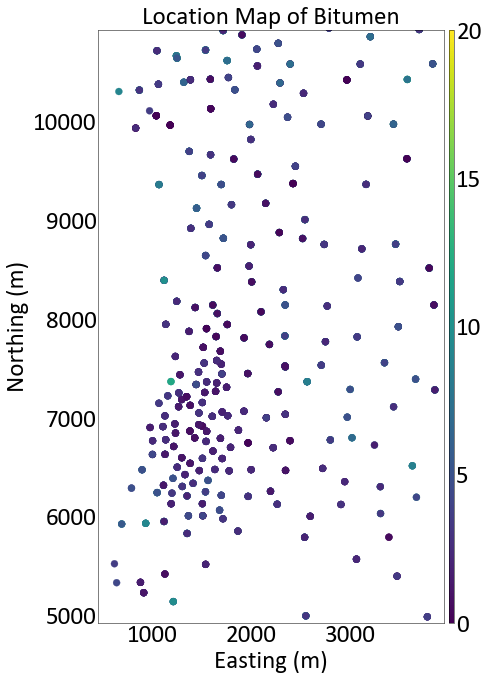

In [12]:
gs.set_style('pt25')

gs.locmap(datafl,var = 'Bitumen',orient='xy', sliceno= 20,slicetol=10, title = ('Location Map of Bitumen'), figsize=(10,10), vlim = (0,20))

plt.tight_layout()


### Declustering

In [13]:
declus = gs.Program('./packages/declus', getpar=True)

C:\Users\gamze\Desktop\SCI Paper 1-son - Major\Codes\Oilsands comparision -OK+SL\tmp7i87jdgq\declus.par has been copied to the clipboard


In [14]:
declusparstr = """                  Parameters for DECLUS
                  *********************

START OF PARAMETERS:
{datafl}         -file with data
{xyzcol}   {varcol}               -  columns for X, Y, Z, and variable
-1.0e21     1.0e21            - trimming limits
declus_ful.sum                  -file for summary output
declus_ful.out                  -file for output with data & weights
1   1                  -Y and Z cell anisotropy (Ysize=size*Yanis)
0                           -0=look for minimum declustered mean (1=max)
100  10.0  200               -number of cell sizes, min size, max size
20                           -number of origin offsets
"""
Data = gs.DataFile(flname='Datanewdiscarded.dat', griddef = griddef, readfl=True)

declus.run(declusparstr.format(datafl = Data.flname,
                           xyzcol = Data.gscol(Data.xyz),
                           varcol = Data.gscol('Bitumen')))
declus_fl = gs.DataFile('declus_ful.out',griddef=griddef)

Calling:  ['./packages/declus', 'temp']

 DECLUS Version: 3.001

  data file = Datanewdiscarded.dat                    
  columns =            2           3           4           5
  tmin,tmax =  -1.0000000E+21  1.0000000E+21
  summary file = declus_ful.sum                          
  output file = declus_ful.out                          
  anisotropy =    1.000000       1.000000    
  minmax flag =            0
  ncell min max =          100   10.00000       200.0000    
  offsets =           20
 

 There are     4749 data with:
   mean value            =      7.77666
   minimum and maximum   =      0.00000    18.42800
   size of data vol in X =   3264.60986
   size of data vol in Y =   5957.88965
   size of data vol in Z =    129.00000

   declustered mean      =      6.98426
   min and max weight    =      0.42826     4.33470
   equal weighting       =      1.00000


 DECLUS Version: 3.001 Finished



In [15]:
declus_sum = gs.DataFile('declus_ful.sum') 
declus_sum.head()

,Cell Size,Declustered Mean
0,0.0,7.776660
1,10.0,7.455724
2,11.9,7.412293
3,13.8,7.332862
4,15.7,7.272089


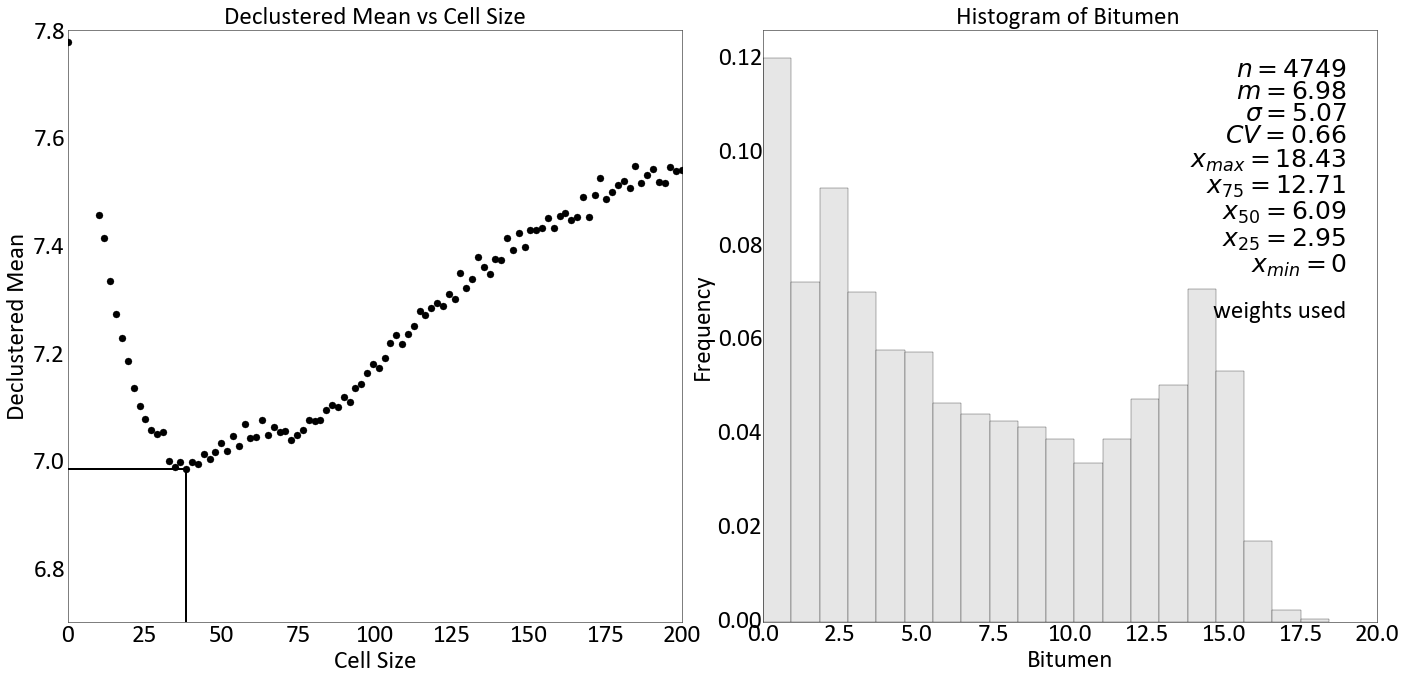

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
gs.set_style('pt25')
ax1.scatter(declus_sum.data['Cell Size'], declus_sum.data['Declustered Mean'], c = 'Black')
ax1.set_title('Declustered Mean vs Cell Size')
ax1.set_xlabel('Cell Size')
ax1.set_ylabel('Declustered Mean')
ax1.set_xlim(0,200)
ax1.set_ylim(6.7, 7.8)
ax1.plot([38.5,38.5], [6.7, 6.984], 'k-', lw=2)
ax1.plot([0,38.5], [6.984,6.984], 'k-', lw=2)
plt.tight_layout()
gs.histplt(declus_fl,var='Bitumen',wt='Declustering Weight',title = 'Histogram of Bitumen ',bins=20,xlim=(0,20),ax=ax2)

plt.savefig('./Figures/Declustered data.png')




## 3.  Data split for CV

In [17]:
kfold = gs.Program('./packages/kfold', getpar=True)

C:\Users\gamze\Desktop\SCI Paper 1-son - Major\Codes\Oilsands comparision -OK+SL\tmpphuxd6gb\kfold.par has been copied to the clipboard


In [18]:
parstr = """                  Parameters for KFOLD
                  ********************

START OF PARAMETERS:
Datanewdiscarded.dat                     -file with data
1   2 3 4    5               -   columns for DH,X,Y,Z,VR
-1.0     1.0e21              -   trimming limits
kfold.out                    -file for output
1                            -write Validation and Training files?
5                            -number of folds
1324978                      -random number seed
0.001  0.01  0.25   0.50              -weights: random, centroid, diff, same
"""
kfold.run(parstr)
kfold_fl = gs.DataFile('kfold.out',griddef=griddef)

Calling:  ['./packages/kfold', 'temp']

 KFOLD Version: 1.000

  data file = Datanewdiscarded.dat                    
  columns =            1           2           3           4           5
  trimming limits =   -1.000000      1.0000000E+21
  file for output = kfold.out                               
  write validation and training data =            1
  number of folds =            5
  random number seed =      1324978
  parameters =   1.0000000E-03  9.9999998E-03  0.2500000      0.5000000    
 
  Number of data:         4749
  Number of drill holes:          228
 
  Getting distance to centroid 
  Centroid    1937.215       7683.185       228.3092    
  Getting distance between all drill holes 
 
  Assigning the data to folds 
 
  number in fold            1  =          962
  number in fold            2  =          955
  number in fold            3  =          941
  number in fold            4  =          952
  number in fold            5  =          939
 
  Writing the output file 


## 4. Machine Learning 

### Hyperparameter tuning

In [19]:
datatest = np.asarray(datafl.data)

#DH Training Data
min_val = np.min(datatest[:,3])
max_val = np.max(datatest[:,3])

print(min_val)
print(max_val)
X = datatest[:,0:3]/100
y = (datatest[:,3]-min_val)/(max_val-min_val)#Scaled
print(X.shape, y.shape)

146.5
275.5
(4749, 3) (4749,)


In [20]:
# # # Hyperparameter Tuning with Grid Search- All models except NN
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RepeatedKFold
# scoring = 'neg_mean_squared_error'
# seed = 7
# models_to_run = [SVR(kernel='rbf', gamma= 'scale'), 
#                  GradientBoostingRegressor(random_state=seed), 
#                  KNeighborsRegressor(), 
#                  RandomForestRegressor(random_state=seed), 
#                  BaggingRegressor(random_state=seed),
#                  ExtraTreesRegressor(random_state=seed),
#                  DecisionTreeRegressor(),
#                  AdaBoostRegressor()]

# models_param_grid = [{ # 1st param grid, corresponding to SVR
#                         'C': [10, 100, 1000],
#                         'epsilon': [0.01, 0.1, 1] 
#                     }, 
#                     { # 2nd param grid, corresponding to GBM
#                         'n_estimators': [300,500,700],
#                         'learning_rate':[0.01, 0.1, 0.2],
#                         'max_depth' : [3,4,6]
#                     },
#                     { # 3rd param grid, corresponding to KNN
#                             'n_neighbors': [11,13,15]
#                     },
#                     { # 4rd param grid, corresponding to RF
#                             'n_estimators': [300,500,700]
#                     },
#                     { # 5rd param grid, corresponding to BAG
#                             'n_estimators' : [300,500,700]
#                     },
#                     { # 7th param grid, corresponding to ET
#                             'n_estimators' : [100,200,300]
#                     },
#                     { # 8th param grid, corresponding to DT
#                             'max_depth' : [4,6,8,10]
#                     },
#                     { # 9th param grid, corresponding to ADA
#                             'n_estimators' : [100,200,300]
#                     }
#                     ]                            

# # define split of data
# kfold = RepeatedKFold(n_splits=5, n_repeats=5, random_state=seed)

# # Tuning
# for i,model in enumerate(models_to_run):
#     grid = GridSearchCV(model, param_grid=models_param_grid[i], scoring=scoring, cv=kfold)
#     grid_result = grid.fit(X, y)
#     print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [21]:
# Best: -0.025390 using {'C': 1000, 'epsilon': 0.1}
# Best: -0.024789 using {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}
# Best: -0.026386 using {'n_neighbors': 15}
# Best: -0.025568 using {'n_estimators': 500}
# Best: -0.025568 using {'n_estimators': 500}
# Best: -0.025573 using {'n_estimators': 100}
# Best: -0.025156 using {'max_depth': 8}
# Best: -0.025273 using {'n_estimators': 300}

In [22]:
# #Tune the Number of Neurons in one Hidden Layer

# def wider_model(neurons=1):
# 	# create model
# 	model = Sequential()
# 	model.add(Dense(neurons, input_dim=3, kernel_initializer='normal', activation='relu'))
# 	model.add(Dense(1, kernel_initializer='normal'))
# 	# Compile model
# 	model.compile(loss='mean_squared_error', optimizer='adam')
# 	return model

# # fix random seed for reproducibility
# seed = 7
# numpy.random.seed(seed)
# model6 = KerasRegressor(build_fn=wider_model, verbose=0, epochs=200,batch_size=60)

# # define the grid search parameters
# neurons = [10,15,20,25]
# param_grid = dict(neurons=neurons)
# grid = GridSearchCV(estimator=model6, param_grid=param_grid, n_jobs=-1, cv=kfold)
# grid_result = grid.fit(X, y)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [23]:
# Best: -0.026321 using {'neurons': 10}
# -0.026321 (0.001486) with: {'neurons': 10}
# -0.026778 (0.001681) with: {'neurons': 15}
# -0.026751 (0.001280) with: {'neurons': 20}
# -0.026452 (0.001535) with: {'neurons': 25}

In [24]:
# #Tune the Number of  Hidden Layers

# def wider_model(optimizer='adam', activation = 'sigmoid', hidden_layers=1):
# 	# create model
# 	model = Sequential()
# 	model.add(Dense(10, input_dim=3, kernel_initializer='normal', activation='relu'))
    
# 	for i in range(hidden_layers):
# 		# Add one hidden layer
# 		model.add(Dense(10, activation=activation))

# 	model.add(Dense(1, kernel_initializer='normal'))
# 	# Compile model
# 	model.compile(loss='mean_squared_error', optimizer='adam')
# 	return model

# # fix random seed for reproducibility
# seed = 7
# numpy.random.seed(seed)
# model6 = KerasRegressor(build_fn=wider_model, verbose=0, epochs=200,batch_size=60)
# hidden_layers =[2,3,4,5]

# param_grid = dict(hidden_layers=hidden_layers)
# grid = GridSearchCV(estimator=model6, param_grid=param_grid, n_jobs=-1, cv=kfold)
# grid_result = grid.fit(X, y)

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [25]:
# Best: -0.026361 using {'hidden_layers': 3}
# -0.026596 (0.001553) with: {'hidden_layers': 2}
# -0.026361 (0.001660) with: {'hidden_layers': 3}
# -0.026381 (0.001969) with: {'hidden_layers': 4}
# -0.026365 (0.001712) with: {'hidden_layers': 5}

In [26]:
# #Tune Batch Size and Number of Epochs

# # define the model
# def wider_model():
# 	# create model
# 	model = Sequential()
# 	model.add(Dense(10, input_dim=3, kernel_initializer='normal', activation='relu'))
# 	model.add(Dense(10, kernel_initializer='normal', activation='relu'))
# 	model.add(Dense(10, kernel_initializer='normal', activation='relu'))
# 	model.add(Dense(1, kernel_initializer='normal'))
# 	# Compile model
# 	model.compile(loss='mean_squared_error', optimizer='adam')
# 	return model

# # fix random seed for reproducibility
# seed = 7
# numpy.random.seed(seed)
# model6 = KerasRegressor(build_fn=wider_model, verbose=0)

# # define the grid search parameters
# batch_size = [10,20, 40, 60, 80, 100]
# epochs = [100,200,300,400,500]
# param_grid = dict(batch_size=batch_size, epochs=epochs)
# grid = GridSearchCV(estimator=model6, param_grid=param_grid, n_jobs=-1, cv=kfold)
# grid_result = grid.fit(X, y)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [27]:
# Best: -0.026316 using {'batch_size': 10, 'epochs': 300}

### Super Learner

In [28]:
# from sklearn.linear_model import LinearRegression
# seed=7

# data = np.asarray(datafl.data)
# min_val = np.min(data[:,4])
# max_val = np.max(data[:,4])
# print(min_val)
# print(max_val)

# #Prediction Grid
# x,Y,Z = griddef.gridcoord()
# X_all = np.hstack((x.reshape(len(x),1),Y.reshape(len(Y),1),Z.reshape(len(Z),1)))/100

# gs.write_gslib(pd.DataFrame(X_all,columns = ['X', 'Y', 'Z']),'./predictions/X_all.dat')

# for fold in range (5):
#     fold  += 1
#     print(fold)
#     pred_all = list()
#     pred_val = list()    
    
#     Training = gs.DataFile(flname='Training0{}.dat'.format(fold), griddef = griddef, readfl=True, tmin = -1e21)
#     datatest = np.asarray(Training.data)
#     X =  datatest[:,[1,2,3]]/100
#     y =  (datatest[:,4:5]- min_val) / (max_val-min_val)

#     Validation= gs.DataFile(flname='Validation0{}.dat'.format(fold), griddef = griddef, readfl=True,tmin = -1e21)
#     datatest = np.asarray(Validation.data)
#     X_val =  datatest[:,[1,2,3]]/100
#     y_val =  (datatest[:,4:5]- min_val) / (max_val-min_val) 

        
#     ###TRAINING

#     # define base model
#     def baseline_model():
#         # create model
#         model = Sequential()
#         model.add(Dense(10, input_dim=3, kernel_initializer='normal', activation='relu'))
#         model.add(Dense(10, kernel_initializer='normal', activation='relu'))
#         model.add(Dense(10, kernel_initializer='normal', activation='relu'))
#         model.add(Dense(1, kernel_initializer='normal'))
#         # Compile model
#         model.compile(loss='mean_squared_error', optimizer='adam')
#         return model

#     # create a list of base-models
#     def get_models():
#         models = list()
#         models.append(SVR(C= 1000,epsilon = 0.1, kernel='rbf', gamma='scale'))
#         models.append(GradientBoostingRegressor(n_estimators = 500, learning_rate = 0.01))
#         models.append(KNeighborsRegressor(n_neighbors=3))
#         models.append(RandomForestRegressor(n_estimators=450))
#         models.append(BaggingRegressor(n_estimators=500))
#         models.append(KerasRegressor(build_fn=baseline_model, epochs=250, verbose=0))
#         models.append(ExtraTreesRegressor(n_estimators=450))
#         models.append(DecisionTreeRegressor())
#         models.append(AdaBoostRegressor(n_estimators=450))
#         return models

#     # collect out of fold predictions form k-fold cross validation

#     def get_out_of_fold_predictions(X, y, models):
#         meta_X, meta_y = list(), list()
#         # define split of data
#         kfold = KFold(n_splits=5, shuffle=True,random_state=seed)
#         # enumerate splits
#         fold_num= 0
#         for train_ix, test_ix in kfold.split(X):
#             fold_num += 1
#             fold_yhats = list()
#             # get data
#             train_X, test_X = X[train_ix], X[test_ix]
#             train_y, test_y = y[train_ix], y[test_ix]
#             meta_y.extend(test_y)
#             # fit and make predictions with each sub-model
#             for model in models:
#                 model.fit(train_X, train_y)
#                 yhat = model.predict(test_X)
#                 # store columns
#                 fold_yhats.append(yhat.reshape(len(yhat),1))
#             # store fold yhats as columns
#             meta_X.append(hstack(fold_yhats))      
#         return vstack(meta_X), asarray(meta_y)

#     # fit all base models on the training dataset
#     def fit_base_models(X, y, models):
#         for model in models:
#             model.fit(X, y)

#     # fit a meta model
#     def fit_meta_model(X, y):
#         model = LinearRegression()
#         model.fit(X, y)
#         return model

#     # make predictions with stacked model
#     def super_learner_predictions(X, models, meta_model):
#         meta_X = list()
#         for model in models:
#             yhat = model.predict(X)
#             meta_X.append(yhat.reshape(len(yhat),1))
#         meta_X = hstack(meta_X)
#         # predict
#         return meta_model.predict(meta_X)

#     # get models
#     models = get_models()

#     # get out of fold predictions
#     meta_X, meta_y = get_out_of_fold_predictions(X, y, models)
#     print('Meta ', meta_X.shape, meta_y.shape)   

#     # fit base models
#     fit_base_models(X, y, models)

#     # fit the meta model
#     meta_model = fit_meta_model(meta_X, meta_y)
        
#     ###VALIDATION
#     y_val_pred = super_learner_predictions(X_val, models, meta_model)
#     print('Stacking Learner Validation: RMSE %.3f' % (sqrt(mean_squared_error(y_val, y_val_pred))))
#     print('Stacking Learner Validation: R2 %.3f' % (r2_score(y_val, y_val_pred)))
#     pred_val.append(y_val_pred.reshape(len(y_val_pred),1))
#     gs.write_gslib(pd.DataFrame(y_val_pred),'./predictions/pred_val{}.dat'.format(fold))
        
#     ###PREDICTION    
#     yhat_all = super_learner_predictions(X_all, models, meta_model)*(max_val-min_val)+min_val
#     pred_all.append(yhat_all.reshape(len(yhat_all),1))
#     gs.write_gslib(pd.DataFrame(yhat_all),'./predictions/pred_all{}.dat'.format(fold))
    

## 5. Variogram Calculation,  Modeling and Kriging for folds

In [29]:
varcalc = gs.Program('./packages/varcalc')
varmodel = gs.Program('./packages/varmodel')
kt3dn = gs.Program('./packages/kt3dn')
declus = gs.Program('./packages/declus') 

In [30]:
declusstr = """                  Parameters for DECLUS
                  *********************

START OF PARAMETERS:
{datafl}         -file with data
{xyzcol}   {varcol}               -  columns for X, Y, Z, and variable
-1.0e21     1.0e21            - trimming limits
declus/declus_{fold}.sum                  -file for summary output
declus/declus_{fold}.out                  -file for output with data & weights
1   1                  -Y and Z cell anisotropy (Ysize=size*Yanis)
0                           -0=look for minimum declustered mean (1=max)
100  10.0  200               -number of cell sizes, min size, max size
20                           -number of origin offsets
"""
varcparstr = """                  Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
{datafl}                 -file with data
{xyzcol}                         -   columns for X, Y, Z coordinates
1   {varcol}                            -   number of variables,column numbers (position used for tail,head variables below)
-99.0    1.0e21                  -   trimming limits
3                                 -number of directions
40 22.5 1000 0.0 22.5 9 0.0   -Dir 01: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 27  70  35                  -        number of lags,lag distance,lag tolerance
130 22.5 1000 0.0 22.5 9 0.0    -Dir 02: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 27  70  35                  -        number of lags,lag distance,lag tolerance
0.  5  1000 -90 5 1000 0.0    -Dir 02: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 8 2 1                -        number of lags,lag distance,lag tolerance
./vargs/varcalc_{fold}.out                      -file for experimental variogram points output.
0                                 -legacy output (0=no, 1=write out gamv2004 format)
1          200                       -run checks for common errors
1                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variogram types
1   1   1   ?                     -tail variable, head variable, variogram type (and cutoff/category), sill

"""
varmparstr = """                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
./vargs/varmodel_{fold}.out                 -file for modeled variogram points output
3                            -number of directions to model points along
  40 0.0  4000   0.5      -  azm, dip, npoints, point separation
  130 0.0  4000   0.5      -  azm, dip, npoints, point separation
  0.0  90.0  1000   0.5      -  azm, dip, npoints, point separation
2    0.07:0.08             -  nst, nugget effect
2    0.25  40.0   0.0   0.0    -it,cc,ang1,ang2,ang3
        400.0  300.0  25.0    -a_hmax, a_hmin, a_vert
2    0.67  40.0   0.0   0.0    -it,cc,ang1,ang2,ang3
      8000.0 4500.0  30.0    -a_hmax, a_hmin, a_vert
1   100000                   -fit model (0=no, 1=yes), maximum iterations
1.0                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{varcalc}                  -    experimental output file 1
3   1  2  3                    -      # of variograms (<=0 for all), variogram #s
1   1   10                   -  # pairs weighting, inverse distance weighting, min pairs
0     10.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
0      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
./vargs/varmodel_{fold}.var              -  file to save fit variogram model
"""
kt3dnparstr = """                 Parameters for KT3DN
                 ********************
START OF PARAMETERS:
{datafl}                            -file with data
0  {xyzcol} {varcol}  0             -  columns for DH,X,Y,Z,var,sec var
-998.0    1.0e21                 -  trimming limits
0                                -option: 0=grid, 1=cross, 2=jackknife
xvk.dat                          -file with jackknife data
2 3  4 5 0                      -   columns for X,Y,Z,vr and sec var
kt3dn_dataspacing.out            -data spacing analysis output file (see note)
0    15.0                        -  number to search (0 for no dataspacing analysis, rec. 10 or 20) and composite length
0    100   0                     -debugging level: 0,3,5,10; max data for GSKV;output total weight of each data?(0=no,1=yes)
kt3dn.dbg-nkt3dn.sum             -file for debugging output (see note)
./predictions/kt3dn_{fold}.out         -file for kriged output (see GSB note)
{griddef}
4   4   4                       -x,y and z block discretization
6    60    12    1               -min, max data for kriging,upper max for ASO,ASO incr
0      0                         -max per octant, max per drillhole (0-> not used)
4000.0  4000.0  4000.0           -maximum search radii
 0     0        0                 -angles for search ellipsoid
1                               -0=SK,1=OK,2=LVM(resid),3=LVM((1-w)*m(u))),4=colo,5=exdrift,6=ICCK
{mean} 0.6  0.8                  -  mean (if 0,4,5,6), corr. (if 4 or 6), var. reduction factor (if 4)
0 0 0 0 0 0 0 0 0                -drift: x,y,z,xx,yy,zz,xy,xz,zy
0                                -0, variable; 1, estimate trend
extdrift.out                     -gridded file with drift/mean
4                                -  column number in gridded file
key_out.out                       -gridded file with keyout (see note)
0    1                           -  column (0 if no keyout) and value to keep
2    0.08                     -nst, nugget effect
2    0.25  40.0   0.0   0.0    -it,cc,ang1,ang2,ang3
        400.0  300.0  25.0    -a_hmax, a_hmin, a_vert
2    0.67  40.0   0.0   0.0    -it,cc,ang1,ang2,ang3
      8000.0 4500.0  30.0    -a_hmax, a_hmin, a_vert
"""

In [31]:
for fold in range(1,6):
    Traindat = gs.DataFile('Training0{}.dat'.format(fold),griddef=griddef)

    declus.run(declusstr.format(datafl = Traindat.flname,
                         xyzcol = Traindat.gscol(Traindat.xyz),
                         varcol = Traindat.gscol('Bitumen'),
                         fold = fold))
    
    mean = np.min(np.asarray(gs.DataFile('declus/declus_{}.sum'.format(fold)).data['Declustered Mean']
                                    [gs.DataFile('declus/declus_{}.sum'.format(fold)).data['Cell Size']>0.0]))

    
    varcalc.run(varcparstr.format(datafl = Traindat.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('Bitumen'),
                             fold = fold))

    varcalcfl = gs.DataFile('./vargs/varcalc_{}.out'.format(fold))

   
    varmodel.run(varmparstr.format(varcalc = varcalcfl.flname,
                                 fold = fold))

    varmodelfl = gs.DataFile('./vargs/varmodel_{}.out'.format(fold))

    f = open("./vargs/varmodel_{}.var".format(fold), "r")
    varg = f.readlines()
    f.close()
    varg = ''.join(varg)
    
    kt3dn.run(kt3dnparstr.format(datafl = Traindat.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('Bitumen'),
                             griddef = griddef,
                             varg = varg,
                             fold = fold,
                             mean = mean))

Calling:  ['./packages/declus', 'temp']

 DECLUS Version: 3.001

  data file = Training01.dat                          
  columns =            2           3           4           5
  tmin,tmax =  -1.0000000E+21  1.0000000E+21
  summary file = declus/declus_1.sum                     
  output file = declus/declus_1.out                     
  anisotropy =    1.000000       1.000000    
  minmax flag =            0
  ncell min max =          100   10.00000       200.0000    
  offsets =           20
 

 There are     3787 data with:
   mean value            =      7.79482
   minimum and maximum   =      0.00000    17.76100
   size of data vol in X =   3264.60986
   size of data vol in Y =   5932.67969
   size of data vol in Z =    129.00000

   declustered mean      =      7.01761
   min and max weight    =      0.57779     4.23225
   equal weighting       =      1.00000


 DECLUS Version: 3.001 Finished

Calling:  ['./packages/varcalc', 'temp']

varcalc version:  1.400

  data file: Trai

  output points file: ./vargs/varmodel_2.out
  number of directions to model points along:            3
  azm, dip, npoints, pointsep:    40.0000000000000       0.000000000000000E+000
        4000  0.500000000000000     
  azm, dip, npoints, pointsep:    130.000000000000       0.000000000000000E+000
        4000  0.500000000000000     
  azm, dip, npoints, pointsep:   0.000000000000000E+000   90.0000000000000     
        1000  0.500000000000000     
  nst =           2
 c0 constrained to  7.000000000000001E-002  8.000000000000000E-002
  fit model?            1      100000
  number of variogram files:            1
  variogram file: ./vargs/varcalc_2.out
  using variograms            1           2           3
  # pairs wt, inv dist wt, min pairs:            1           1          10
  fixhmaxvert,hmaxvert:            0   10.0000000000000     
  fixhminhmax,hminhmax:            0   1.00000000000000     
  variogram model output file: ./vargs/varmodel_2.var
 Reading experimental variogram

 Final objective value =   1.743281092621643E-004
  Modeling points

varmodel completed successfully

Calling:  ['./packages/kt3dn', 'temp']

 KT3DN Version: 7.5.0

  data file = Training03.dat                          
  columns =            0           2           3           4           5
           0
  trimming limits =   -998.000000000000       1.000000000000000E+021
  kriging option =            0
  jackknife data file = xvk.dat                                 
  columns =            2           3           4           5           0
  data spacing analysis output file = kt3dn_dataspacing.out                   
  debugging level =            0
  summary only file = kt3dn.sum                               
  debugging file = kt3dn.dbg                               
  GSLIB-style output file = ./predictions/kt3dn_3.out               
  nx, xmn, xsiz =           35   500.000000000000        100.000000000000     
  ny, ymn, ysiz =           60   5000.00000000000        100.00000000000

   currently on estimate      3150
   currently on estimate      6300
   currently on estimate      9450
   currently on estimate     12600
   currently on estimate     15750
   currently on estimate     18900
   currently on estimate     22050
   currently on estimate     25200
   currently on estimate     28350
   currently on estimate     31500

 KT3DN Version:    7.5.0 Finished

Calling:  ['./packages/declus', 'temp']

 DECLUS Version: 3.001

  data file = Training05.dat                          
  columns =            2           3           4           5
  tmin,tmax =  -1.0000000E+21  1.0000000E+21
  summary file = declus/declus_5.sum                     
  output file = declus/declus_5.out                     
  anisotropy =    1.000000       1.000000    
  minmax flag =            0
  ncell min max =          100   10.00000       200.0000    
  offsets =           20
 

 There are     3810 data with:
   mean value            =      7.79743
   minimum and maximum   =      0.0000

## 6. The combination of kriging and super learner

### Weights and Optimization

In [1]:
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize

In [33]:
i=0
for Fold in range(1,6):
    i += 1
    testfile = gs.DataFile('Validation0{}.dat'.format(Fold))
#     testfile = gs.DataFile('oilsands.dat')
    pltdat_kt3dn = gs.DataFile('./predictions/kt3dn_{}.out'.format(Fold),griddef=griddef)
    pltdat_ml = gs.DataFile('./predictions/pred_all{}.dat'.format(Fold),griddef=griddef)
    
    idx,ingrid = griddef.coord_to_index1d(x=testfile.data['East'],y=testfile.data['North'],z=testfile.data['Elevation'])
    testfile.data = testfile.data[idx >= 0]
    idx = idx[idx>=0]
#################################################################################
###All
    columns =['Estimate']
    OK_all = pltdat_kt3dn.data['Estimate'].values
    OK_variance_all = pltdat_kt3dn.data['EstimationVariance'].values
    ML_all = pltdat_ml['0']

    minOK_val_all = np.min(OK_variance_all)
    maxOK_val_all = np.max(OK_variance_all)

    OK_st_variance_all= (OK_variance_all-minOK_val_all)/(maxOK_val_all-minOK_val_all)

    W_all  = hstack(OK_st_variance_all+ 0.0000000000000001)                                                     
    OK_all = hstack(OK_all)                                                     
    ML_all = hstack(ML_all)
##################################################################################
##Each fold
    OK = array(pltdat_kt3dn.data['Estimate'][idx].values).reshape((len(pltdat_kt3dn.data['Estimate'][idx]), 1))
    ML = array(pltdat_ml['0'][idx]).reshape((len(pltdat_ml['0'][idx]), 1))
    gs.write_gslib(pd.DataFrame(OK, columns=columns ),'./predictions/OK_{}.dat'.format(Fold))
    
    OK_variance = array(pltdat_kt3dn['EstimationVariance'][idx].values).reshape((len(pltdat_kt3dn['EstimationVariance'][idx].values), 1))
    gs.write_gslib(pd.DataFrame(OK_variance, columns =['EstimationVariance']),'./predictions/OK_var{}.dat'.format(Fold))
                   
    min_val = np.min(OK_variance)
    max_val = np.max(OK_variance)
#     print(min_val)
#     print(max_val)   
    
    OK_st_variance= (OK_variance-min_val)/(max_val-min_val)  
    gs.write_gslib(pd.DataFrame(OK_st_variance),'./predictions/OK_st_var{}.dat'.format(Fold))     

    W  = hstack(OK_st_variance+ 0.0000000000000001)
    OK = hstack(OK)
    ML = hstack(ML)

##################################################################################
##Optimisation
    
    def objective(weights):
        b0, b1 = weights[0], weights[1]
        for weight in zip(weights):
            final_prediction = W ** ((b0 + b1 * OK)) *ML+ (1-W+0.0000000000000001) ** ((b0 + b1 * OK)) * OK
        return sqrt(mean_squared_error(testfile.data['Bitumen'], final_prediction))

    starting_values = [0.5, 0]
    res = minimize(objective, starting_values, method='SLSQP', options={'disp': True, 'ftol':1e-100})

    print('Ensemble Score: {best_score}'.format(best_score=res['fun']))
    print('Best Weights: {weights}'.format(weights=res['x']))
    
#     superlearner_val_opt = hstack(W ** ((res['x'][0]+res['x'][1]* OK)) * ML+
#                               (1-W) ** ((res['x'][0]+res['x'][1]* OK)) * OK)
#     gs.write_gslib(pd.DataFrame(superlearner_val_opt),'./predictions/superlearner_val_opt{}.dat'.format(Fold))


    superlearner_all_opt = hstack(W_all ** ((res['x'][0]+res['x'][1]* OK_all)) * ML_all+ 
                          (1-W_all+0.0000000000000001) ** ((res['x'][0]+res['x'][1] * OK_all)) * OK_all)
    
    gs.write_gslib(pd.DataFrame(superlearner_all_opt),'./predictions/superlearner_all_opt{}.dat'.format(Fold))
    
    

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.36805458182159
            Iterations: 11
            Function evaluations: 54
            Gradient evaluations: 11
Ensemble Score: 3.36805458182159
Best Weights: [0.91219694 0.00196977]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.2317562975172374
            Iterations: 11
            Function evaluations: 44
            Gradient evaluations: 11
Ensemble Score: 3.2317562975172374
Best Weights: [ 1.16370571 -0.01668088]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.4276737239807424
            Iterations: 12
            Function evaluations: 57
            Gradient evaluations: 12
Ensemble Score: 3.4276737239807424
Best Weights: [0.77259103 0.02580096]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.3817595319408653
            Iterations: 15
            Funct

## 7. Comparision of Kriging and Kriging + Super Learner

In [5]:
slinceno=9
vlim =(0,19)
pltlim = (0,25)
i=0

gs.set_style('pt35')

krig_av = np.zeros(shape=(31500,1))
ML_av = np.zeros(shape=(31500,1))
SL_av = np.zeros(shape=(31500,1))

KRG_R2 = 0
KRG_RMSE = 0
ML_R2 = 0
ML_RMSE = 0
SL_R2 = 0
SL_RMSE =0

test= gs.DataFile('Datatest.dat', griddef= griddef)

for Fold in range(0,5):
    Fold +=1
    i += 1
    testfile = gs.DataFile('Validation0{}.dat'.format(Fold))
    pltdat_kt3dn = gs.DataFile('./predictions/kt3dn_{}.out'.format(Fold),griddef=griddef)
    pltdat_ml = gs.DataFile('./predictions/pred_all{}.dat'.format(Fold),griddef=griddef)
    combined = gs.DataFile('./predictions/superlearner_all_opt{}.dat'.format(Fold),griddef=griddef)
    
    declus = gs.DataFile('./declus/declus_{}.out'.format(Fold)) 

    pltdat_ml.data['0'][pltdat_ml.data['0'] < 0] = 0
    combined.data['0'][combined.data['0'] < 0] = 0
    
    pltdat_ml = gaussian_filter(pltdat_ml.data['0'],sigma = 0)
    combined = gaussian_filter(combined.data['0'],sigma = 0)    

    
    krig_av = krig_av +  pltdat_kt3dn.data['Estimate'].values.reshape(len(pltdat_kt3dn.data['Estimate']),1)
    ML_av = ML_av + pltdat_ml.reshape(len(pltdat_kt3dn.data['Estimate']),1)
    SL_av = SL_av + combined.reshape(len(pltdat_kt3dn.data['Estimate']),1)

    idx,ingrid = griddef.coord_to_index1d(x=testfile.data['East'],y=testfile.data['North'],z=testfile.data['Elevation'])
    idx_2,ingrid = griddef.coord_to_index1d(x=test.data['East'],y=test.data['North'],z=test.data['Elevation'])
    testfile.data = testfile.data[idx >= 0]
    idx = idx[idx>=0]
    
################################################################################################################   

    KRG_R2 = KRG_R2 + r2_score(testfile.data['Bitumen'],pltdat_kt3dn.data['Estimate'][idx].values)
    KRG_RMSE = KRG_RMSE + mean_squared_error(testfile.data['Bitumen'],pltdat_kt3dn.data['Estimate'][idx].values)
    ML_R2 = ML_R2 + r2_score(testfile.data['Bitumen'],pltdat_ml[idx])           
    ML_RMSE = ML_RMSE + mean_squared_error(testfile.data['Bitumen'],pltdat_ml[idx])   
    SL_R2 = SL_R2 + r2_score(testfile.data['Bitumen'],combined[idx])           
    SL_RMSE = SL_RMSE + mean_squared_error(testfile.data['Bitumen'],combined[idx]) 

################################################################################################################   
krig_av = pd.DataFrame((krig_av/i),columns = ['Estimate'])
ML_av = pd.DataFrame((ML_av/i),columns = ['0'])
SL_av = pd.DataFrame((SL_av/i),columns = ['0'])

test = pd.DataFrame((test.data),columns = ['Bitumen'])
idx_2 = pd.DataFrame((idx_2),columns = ['0'])

test = test['Bitumen'][idx_2['0'] >= 0]
idx_2 = idx_2['0'][idx_2['0'] >= 0]



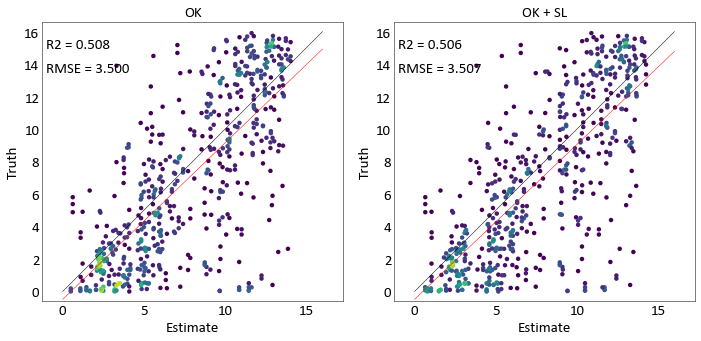

In [13]:
gs.set_style('pt15')
pltlim = (0,16)

stat_blk = []

KR = gs.DataFile('C:/Users/gamze/Desktop/SCI Paper 1-son - Major/Codes/Oilsands comparision -OK/predictions/KRG.out')


f, axes = plt.subplots(1, 2, figsize=(10,5))


ax1 = gs.scatxval(KR.data,test,xlabel='Estimate', ylabel='Truth',ms=20,
    title = 'OK',dens=True,ax = axes[0],vlim = pltlim, stat_blk = stat_blk)
ax1.text(-1,15,'R2 = {0:.3f}'.format(r2_score(test,KR.data)), size = 15)
ax1.text(-1,13.5,'RMSE = {0:.3f}'.format(sqrt(mean_squared_error(test,KR.data))), size =15)

ax2 = gs.scatxval(SL_av['0'][idx_2].values,test,xlabel='Estimate', ylabel='Truth',ms=20,
    title = 'OK + SL',dens=True,ax = axes[1],vlim = pltlim, stat_blk = stat_blk)
ax2.text(-1,15,'R2 = {0:.3f}'.format(r2_score(test,SL_av['0'][idx_2].values)), size =15)
ax2.text(-1,13.5,'RMSE = {0:.3f}'.format(sqrt(mean_squared_error(test,SL_av['0'][idx_2].values))), size =15)

plt.tight_layout()
plt.savefig('./Figures/DH.png',bbox_inches = 'tight', dpi = 150)

